In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [22]:
mainDir = 'D:\\Study\\S6\\Practicum Machine Learning\\Gemastik\\lego2\\The IQ-OTHNCCD lung cancer dataset'
batch_size = 32
target_size=(128, 128)

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [24]:
train_generator = train_datagen.flow_from_directory(
    mainDir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

Found 878 images belonging to 3 classes.


In [25]:
validation_generator = train_datagen.flow_from_directory(
    mainDir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

Found 219 images belonging to 3 classes.


In [26]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     mainDir,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle=False
# )

In [30]:
def extract_data(generator, sigma=1.0):
    data = []
    labels = []
    for i in range(len(generator)):
        x, y = next(generator)
        x_blurred = np.array([gaussian_filter(image, sigma=sigma) for image in x])
        data.extend(x_blurred)
        labels.extend(y)
    return np.array(data), np.array(labels)

In [31]:
X_train, y_train = extract_data(train_generator)
X_val, y_val = extract_data(validation_generator)

In [32]:
nsamples, nx, ny, nz = X_train.shape
X_train_reshaped = X_train.reshape((nsamples, nx*ny*nz))

In [33]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

In [34]:
X_resampled = X_resampled.reshape((X_resampled.shape[0], nx, ny, nz))
y_resampled = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

In [35]:
print(f"Class distribution before SMOTE: {Counter(np.argmax(y_train, axis=1))}")
print(f"Class distribution after SMOTE: {Counter(np.argmax(y_resampled, axis=1))}")

Class distribution before SMOTE: Counter({1: 449, 2: 333, 0: 96})
Class distribution after SMOTE: Counter({1: 449, 0: 449, 2: 449})


In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

C:\Users\dephm\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217,539 (50.42 MB)

 Trainable params: 13,216,643 (50.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [40]:
history = model.fit(
    X_resampled, y_resampled,
    batch_size=batch_size,
    epochs=50,
    validation_data=(X_val, y_val),
    # callbacks=callbacks,
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4567 - loss: 71.2195 - val_accuracy: 0.1096 - val_loss: 70.5056
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7011 - loss: 59.1832 - val_accuracy: 0.1096 - val_loss: 67.0224
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7757 - loss: 48.2930 - val_accuracy: 0.1096 - val_loss: 60.2365
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8037 - loss: 39.0144 - val_accuracy: 0.1096 - val_loss: 52.8297
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8654 - loss: 31.3379 - val_accuracy: 0.1096 - val_loss: 46.7384
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8847 - loss: 25.1576 - val_accuracy: 0.1096 - val_loss: 40.2478
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8750 - loss: 20.2649 - val_accuracy: 0.2557 - val_loss: 33.3681
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9015 - loss: 16.2944 - val_accuracy: 0.3

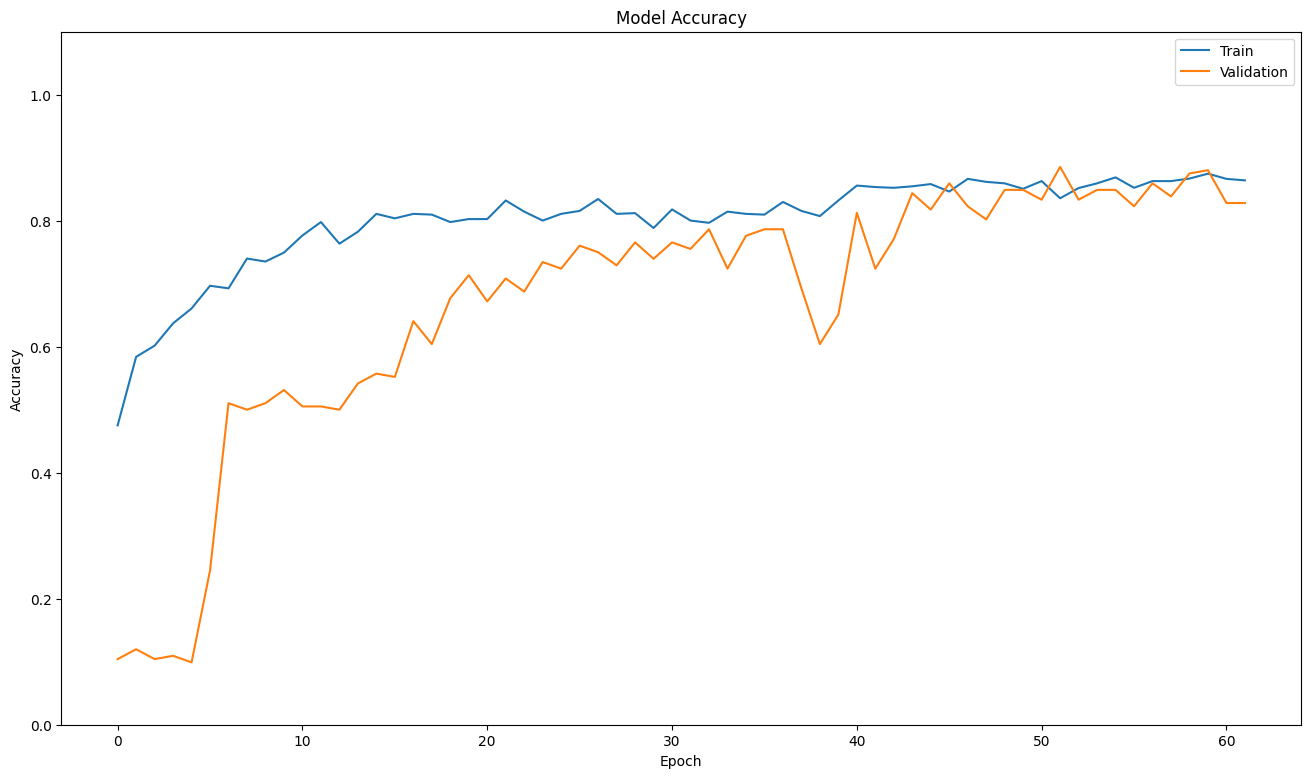

In [ ]:
def plot_hist_Accuracy(hist):
    plt.figure(figsize=(16, 9))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc = "upper right")
    plt.ylim(0,1.1)
    plt.show()

plot_hist_Accuracy(history)

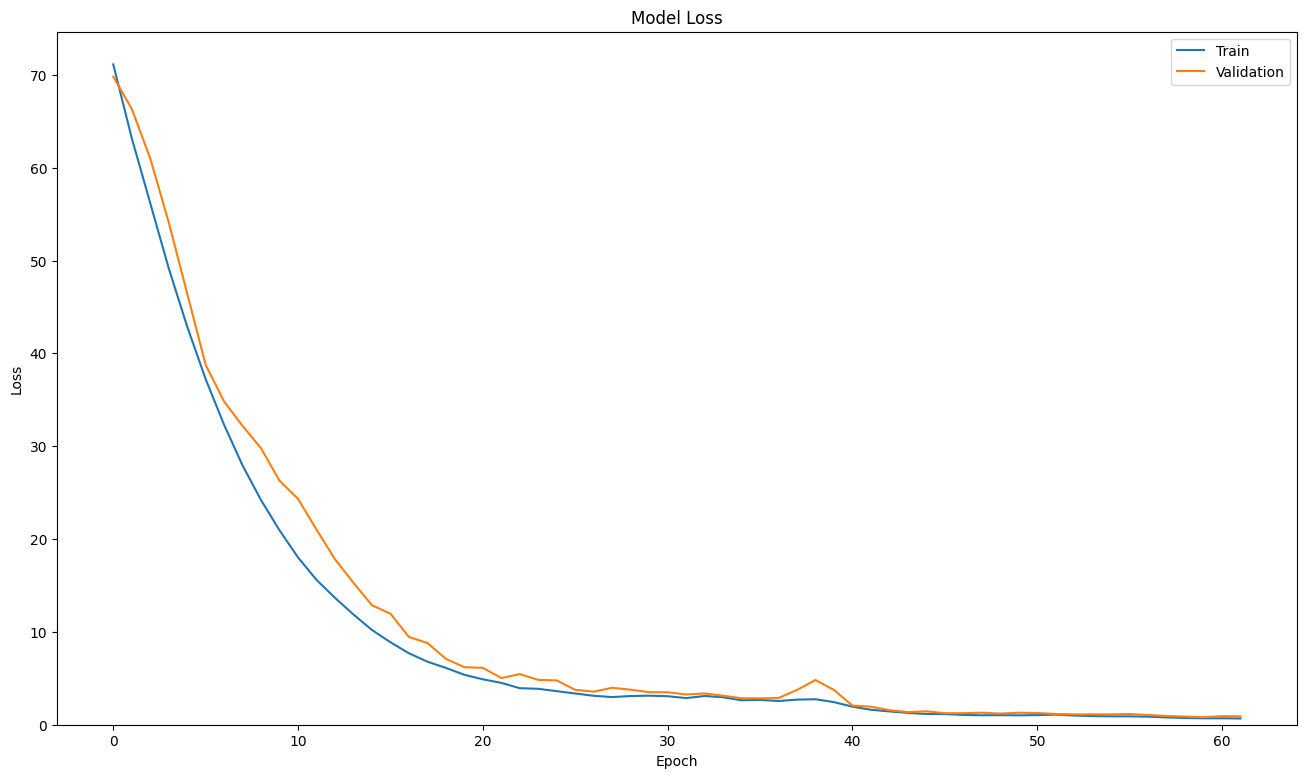

In [ ]:
# Plot training & validation loss values
def plot_hist_loss(hist):
    plt.figure(figsize=(16, 9))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(["Train", "Validation"], loc = "upper right")
    plt.ylim(0,)
    plt.show()

plot_hist_loss(history)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# import matplotlib.pyplot as plt

# mainDir = 'D:\\Study\\S6\\Practicum Machine Learning\\Gemastik\\lego2\\The IQ-OTHNCCD lung cancer dataset'
# batch_size = 32

# # Original Data Generators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     mainDir,
#     target_size=(128, 128),  # Reduced target size
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',  # Specify grayscale input here
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     mainDir,
#     target_size=(128, 128),  # Reduced target size
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',  # Specify grayscale input here
#     subset='validation'
# )

# # Function to extract data and labels from generator
# def extract_data(generator):
#     data = []
#     labels = []
#     for i in range(len(generator)):
#         x, y = next(generator)
#         data.extend(x)
#         labels.extend(y)
#     return np.array(data), np.array(labels)

# # Extract training data and labels
# X_train, y_train = extract_data(train_generator)
# X_val, y_val = extract_data(validation_generator)

# # Reshape data to 2D
# nsamples, nx, ny, nz = X_train.shape
# X_train_reshaped = X_train.reshape((nsamples, nx*ny*nz))

# # Apply SMOTE to the training data
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

# # Reshape back to original shape
# X_resampled = X_resampled.reshape((X_resampled.shape[0], nx, ny, nz))
# y_resampled = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

# # Verify class distribution after SMote
# print(f"Class distribution before SMOTE: {Counter(np.argmax(y_train, axis=1))}")
# print(f"Class distribution after SMOTE: {Counter(np.argmax(y_resampled, axis=1))}")

# # Model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Flatten(),
    
#     tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
# ]

# # Train the model with resampled data
# history = model.fit(
#     X_resampled, y_resampled,
#     batch_size=batch_size,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks,
# )

# def plot_hist_Accuracy(hist):
#     plt.figure(figsize=(16, 9))
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.title("Model Accuracy")
#     plt.ylabel("Accuracy")
#     plt.xlabel("Epoch")
#     plt.legend(["Train", "Validation"], loc = "upper right")
#     plt.ylim(0,1.1)
#     plt.show()

# plot_hist_Accuracy(history)

# def plot_hist_loss(hist):
#     plt.figure(figsize=(16, 9))
#     plt.plot(hist.history['loss'], label='Training Loss')
#     plt.plot(hist.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(["Train", "Validation"], loc = "upper right")
#     plt.ylim(0,)
#     plt.show()

# plot_hist_loss(history)


Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


AttributeError: module 'numpy' has no attribute 'matrix'

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter

# mainDir = 'D:\\Study\\S6\\Practicum Machine Learning\\Gemastik\\lego2\\The IQ-OTHNCCD lung cancer dataset'
# batch_size = 32

# # Original Data Generators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     mainDir,
#     target_size=(128, 128),  # Reduced target size
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',  # Specify grayscale input here
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     mainDir,
#     target_size=(128, 128),  # Reduced target size
#     batch_size=batch_size,
#     class_mode='categorical',
#     color_mode='grayscale',  # Specify grayscale input here
#     subset='validation'
# )

# # Function to extract data and labels from generator with Gaussian blur
# def extract_data(generator, sigma=1.0):
#     data = []
#     labels = []
#     for i in range(len(generator)):
#         x, y = next(generator)
#         x_blurred = np.array([gaussian_filter(image, sigma=sigma) for image in x])
#         data.extend(x_blurred)
#         labels.extend(y)
#     return np.array(data), np.array(labels)

# # Extract training data and labels with Gaussian blur
# X_train, y_train = extract_data(train_generator)
# X_val, y_val = extract_data(validation_generator)

# # Reshape data to 2D
# nsamples, nx, ny, nz = X_train.shape
# X_train_reshaped = X_train.reshape((nsamples, nx*ny*nz))

# # Apply SMOTE to the training data
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

# # Reshape back to original shape
# X_resampled = X_resampled.reshape((X_resampled.shape[0], nx, ny, nz))
# y_resampled = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

# # Verify class distribution after SMOTE
# print(f"Class distribution before SMOTE: {Counter(np.argmax(y_train, axis=1))}")
# print(f"Class distribution after SMOTE: {Counter(np.argmax(y_resampled, axis=1))}")

# # Model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Flatten(),
    
#     tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
# ]

# # Train the model with resampled data
# history = model.fit(
#     X_resampled, y_resampled,
#     batch_size=batch_size,
#     epochs=50,
#     validation_data=(X_val, y_val),
#     # callbacks=callbacks,
# )

# def plot_hist_Accuracy(hist):
#     plt.figure(figsize=(16, 9))
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.title("Model Accuracy")
#     plt.ylabel("Accuracy")
#     plt.xlabel("Epoch")
#     plt.legend(["Train", "Validation"], loc = "upper right")
#     plt.ylim(0,1.1)
#     plt.show()

# plot_hist_Accuracy(history)

# def plot_hist_loss(hist):
#     plt.figure(figsize=(16, 9))
#     plt.plot(hist.history['loss'], label='Training Loss')
#     plt.plot(hist.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(["Train", "Validation"], loc = "upper right")
#     plt.ylim(0,)
#     plt.show()

# plot_hist_loss(history)

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Class distribution before SMOTE: Counter({1: 449, 2: 333, 0: 96})
Class distribution after SMOTE: Counter({2: 449, 1: 449, 0: 449})


C:\Users\dephm\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4461 - loss: 71.4560 - val_accuracy: 0.1096 - val_loss: 69.2867 - learning_rate: 1.0000e-04
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6568 - loss: 60.7813 - val_accuracy: 0.1096 - val_loss: 64.7504 - learning_rate: 1.0000e-04
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7431 - loss: 50.4200 - val_accuracy: 0.1096 - val_loss: 56.9323 - learning_rate: 1.0000e-04
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8058 - loss: 40.9939 - val_accuracy: 0.1324 - val_loss: 49.6935 - learning_rate: 1.0000e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8388 - loss: 33.0258 - val_accuracy: 0.3790 - val_loss: 43.3309 - learning_rate: 1.0000e-04
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8446 - loss: 26.5494 - val_accuracy: 0.3790 - val_loss: 39.0597 - learning_rate: 1.0000e-04
Epoch 7/100
11/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accur

KeyboardInterrupt: 